### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.

Utah State University, 2025.

File '03_df_bands_structure_VI_LAI_NDVIc.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

In this file, we will try to use all available predictants for model LAI, we have already generated VIs from a list.

### Instructions
- if not, create a anaconda environment, e.g. 
```bash
conda create -n pysr
```
- once completed the step above in the pysr environment install these modules:
```bash
conda install pysr
conda install matplotlib
pip install skillmetrics
```
- final step, in the activated environment and pass this command:
```bash
- python -c "import pysr"
```
- last commands will install julia libraries, necessary to run the notebook.

- To visualize the results install Jinja2
```bash
conda install jinja2
```



### Running PySR 

Julia and Julia dependencies are installed at first import:

In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [2]:
import warnings
warnings.filterwarnings('ignore')

import sympy
import numpy as np
import pandas as pd
import skill_metrics as sm
import mpl_scatter_density # adds projection='scatter_density'

from pysr import PySRRegressor
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

### Set up PySR run:


using Sergio's data

In [3]:
# df = pd.read_csv('03_df_bands_structure_VI_LAI_NDVIc.csv')
df = pd.read_csv(r"C:\github\PySR_ATeam_sac\examples\LAI_vineyard_equations\Data\03_df_bands_structure_VI_LAI_NDVIc.csv")
# print(df.head())
X = df.iloc[:,1:-2]
y = df.iloc[:,-2]
print(X.head())
print(y.head())

        Red     Green      Blue       NIR        FC   c_depth        CH  \
0  0.035958  0.053953  0.005338  0.342562  0.439236  1.429447  1.972603   
1  0.035262  0.053063  0.005320  0.340711  0.383681  1.474576  1.946317   
2  0.038239  0.053274  0.005266  0.329618  0.274306  1.550626  1.988539   
3  0.039237  0.053812  0.005251  0.324419  0.307292  1.559624  2.024439   
4  0.038143  0.049900  0.005562  0.285435  0.130208  1.447568  1.946801   

        AVI        BAI       BCC  ...       TGI       TVI      TriVI  \
0  0.466092  11.912866  0.056041  ...  3.546720  1.144556  19.116052   
1  0.464776  12.049737  0.056810  ...  3.487633  1.145609  19.038924   
2  0.452042  13.070470  0.054412  ...  3.406700  1.136705  18.084147   
3  0.446288  13.585168  0.053416  ...  3.423772  1.133230  17.693954   
4  0.407953  18.299150  0.059423  ...  3.071745  1.124386  15.307835   

       VARI       VIG   VgNIRBI   VrNIRBI     NDVIf    TSAVIm     TSAVIg  
0  0.212772  0.200140 -0.727865 -0.810007

key pySR parameters to be changed:

In [4]:
niterations = 1000000  # for short runs, set this to a 100, for longer runs, set this to 10 million
timeout_in_seconds = 60*60*24  # this line will make the code stop after 2 hours, change it as desired.
elementwise_loss = "L2DistLoss()"  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options

binary_operators = ["+", "*","-","/","^"] # these are the default binary operators (use these for basic equations)
# binary_operators = ["+", "*","-","/","^","ND(x,y) = ((x-y)/(x+y))", "SR(x,y)=x/y"]  # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
unary_operators = ["sqrt", "inv(x)=1/x"]  # other basic operators can be added here

# unary_operators = ["sqrt", "exp", "log", "inv(x)=1/x"]  # other basic operators can be added here
extra_sympy_mappings = {"inv": lambda x: 1 / x,"ND": lambda x, y: ((x- y)/(x+y)),"SR": lambda x, y: x/y}  # here the format of the sought expressions are defined

The default parameters will help speed up code and ensure repeteability of run

In [5]:
default_pysr_params = dict(
    model_selection="best", #"score", "best", see documentation for more options
    random_state=0, # seed number to ensure reproducible results across different runs
    deterministic=True, #   to ensure reproducible results across different runs
    parallelism="serial", # to ensure reproducible results across different runs
    maxsize=50, # maximum complexity of the equations, increase to 100 for more complex equations, reduce to 20 for less complex equations   
    select_k_features=10, # to automatically select few predictors (using random forest) from set of predictors, activate/deactive as you wish
    # denoise=True, # to remove scattering on y, activate/deactivate as you wish
    verbosity =0,   # 0 for no output, 1 for some output
    elementwise_loss= "L2DistLoss()",  #  (mean square) can be changed to "L1DistLoss()" for mean absolute error, see link at the end for more options
    )

In [6]:
# Learn equations
model = PySRRegressor(
    niterations=niterations,  # for short runs, set this to a 100, for longer runs, set this to 10 million
    timeout_in_seconds=timeout_in_seconds,  # this line will make the code stop after 2 hours
    binary_operators=binary_operators, # activate this line to use simple ratio and normalized diference functions (comment the repvious line)
    unary_operators=unary_operators, # other basic operators can be added here
    extra_sympy_mappings=extra_sympy_mappings, # here the format of the sought expressions are defined
    turbo=True, # set to True to speed up the code 
    **default_pysr_params,
)

model.fit(X, y)


Using features ['Blue' 'FC' 'CH' 'BCC' 'BNDVI' 'GBNDVI' 'IKAW' 'MRBVI' 'PISI' 'NDVIf']


,model_selection,'best'
,binary_operators,"['+', '*', ...]"
,unary_operators,"['sqrt', 'inv(x)=1/x']"
,expression_spec,None
,niterations,1000000
,populations,31
,population_size,27
,max_evals,None
,maxsize,50
,maxdepth,None
,warmup_maxsize_by,None


In [18]:
# Save the trained model to a pickle file
import joblib
joblib.dump(model, "pysr_NDVIc_filtered_rf_model.pkl")

['pysr_NDVIc_filtered_rf_model.pkl']

We can print the model pareto curve, which will showcase the trend of discovered solutions:

In [9]:
best_score=model.get_best().score

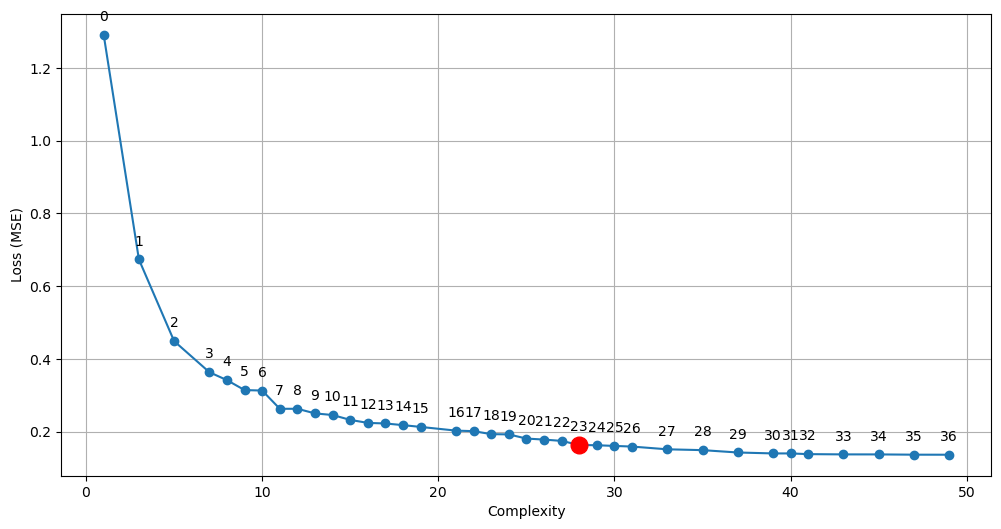

In [10]:
# best scoring equation (not the one with the lowest loss nor the one with the lowest complexity, but the one that optimally balances the two)
scores = model.equations_.score
# get the index of the first max
# max_index = scores.idxmax(axis=0)
max_index = scores == best_score
max_index


pareto =model.equations_.iloc[:, [0, 1]] # Print the equations found
# pareto

# ---- Bigger figure here ----
plt.figure(figsize=(12, 6))
plt.plot(pareto.complexity,pareto.loss,'-o')
plt.plot(pareto.complexity[max_index],pareto.loss[max_index],'ro',markersize=12)
plt.grid(True)
plt.xlabel("Complexity")
plt.ylabel("Loss (MSE)")



ii=0
# zip joins x and y coordinates in pairs
for p,q, in zip(pareto.complexity,pareto.loss):

    label = "{:.0f}".format(ii)

    plt.annotate(label, # this is the text
                 (p,q), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ii=ii+1
plt.show()

We can also view the SymPy format of the equation of our interest:

In [11]:
unique_max_index = max_index[max_index].index.tolist()
model.sympy(unique_max_index[0])  # get the selected equation in sympy format

sqrt(1.9772595**(3.703214 - (FC**((IKAW - MRBVI + 0.261232)/PISI))**(27.770678**MRBVI + 3.7268252*CH - 6.77252501865492)) + 7.3130026**FC)

In [12]:
print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                           2.367226   
	1         0.325454                                      3.435736 / CH   
	2         0.202856                              2.5135517 / (CH - FC)   
	3         0.105526                (2.8160737 - (CH - FC)) ^ 1.7092284   
	4         0.062136          (2.5991073 - (CH - sqrt(FC))) ^ 1.7098085   
	5         0.083321  4.016769 ^ (FC ^ (0.060276054 / (CH ^ -4.83016)))   
	6         0.004111  5.762493 / (((CH - sqrt(FC)) ^ 3.2897668) + 1....   
	7         0.174532  3.9471369 ^ (GBNDVI ^ ((0.039051346 / FC) / (C...   
	8         0.000020  3.9443617 ^ sqrt(GBNDVI ^ ((0.07755519 / FC) /...   
	9         0.049507  3.0603359 ^ ((NDVIf ^ ((0.00916037 / FC) / (CH...   
	10        0.017816  3.6747155 ^ (0.49573642 ^ (((0.045080904 / FC)...   
	11        0.056399  2.9996157 ^ ((GBNDVI ^ (((0.054718662 / FC) / ...   
	12      

We can also view the form of any other expression in the list, using the index of it in `model.equations_`.

In [13]:
found_equations =model.equations_.iloc[:, [1,2]]  # print all the equations found
# pd.set_option('display.max_colwidth',200)  
# display(found_equations)

# Apply a color ramp to the 'Score' column
styled_df = found_equations.style.background_gradient(
    subset=['loss'],  # Column to apply gradient
    cmap='jet'      # Color map matplotlib colormap name
)

# Display in Jupyter Notebook
styled_df

,loss,equation
0,1.291319,2.367226
1,0.673516,3.435736 / CH
2,0.448900,2.5135517 / (CH - FC)
3,0.363489,(2.8160737 - (CH - FC)) ^ 1.7092284
4,0.341590,(2.5991073 - (CH - sqrt(FC))) ^ 1.7098085
5,0.314282,4.016769 ^ (FC ^ (0.060276054 / (CH ^ -4.83016)))
6,0.312993,5.762493 / (((CH - sqrt(FC)) ^ 3.2897668) + 1.515585)
7,0.262867,3.9471369 ^ (GBNDVI ^ ((0.039051346 / FC) / (CH ^ -5.499508)))
8,0.262862,3.9443617 ^ sqrt(GBNDVI ^ ((0.07755519 / FC) / (CH ^ -5.504806)))
9,0.250165,3.0603359 ^ ((NDVIf ^ ((0.00916037 / FC) / (CH ^ -7.1655283))) - PISI)


## Output

Plotting the first solutions

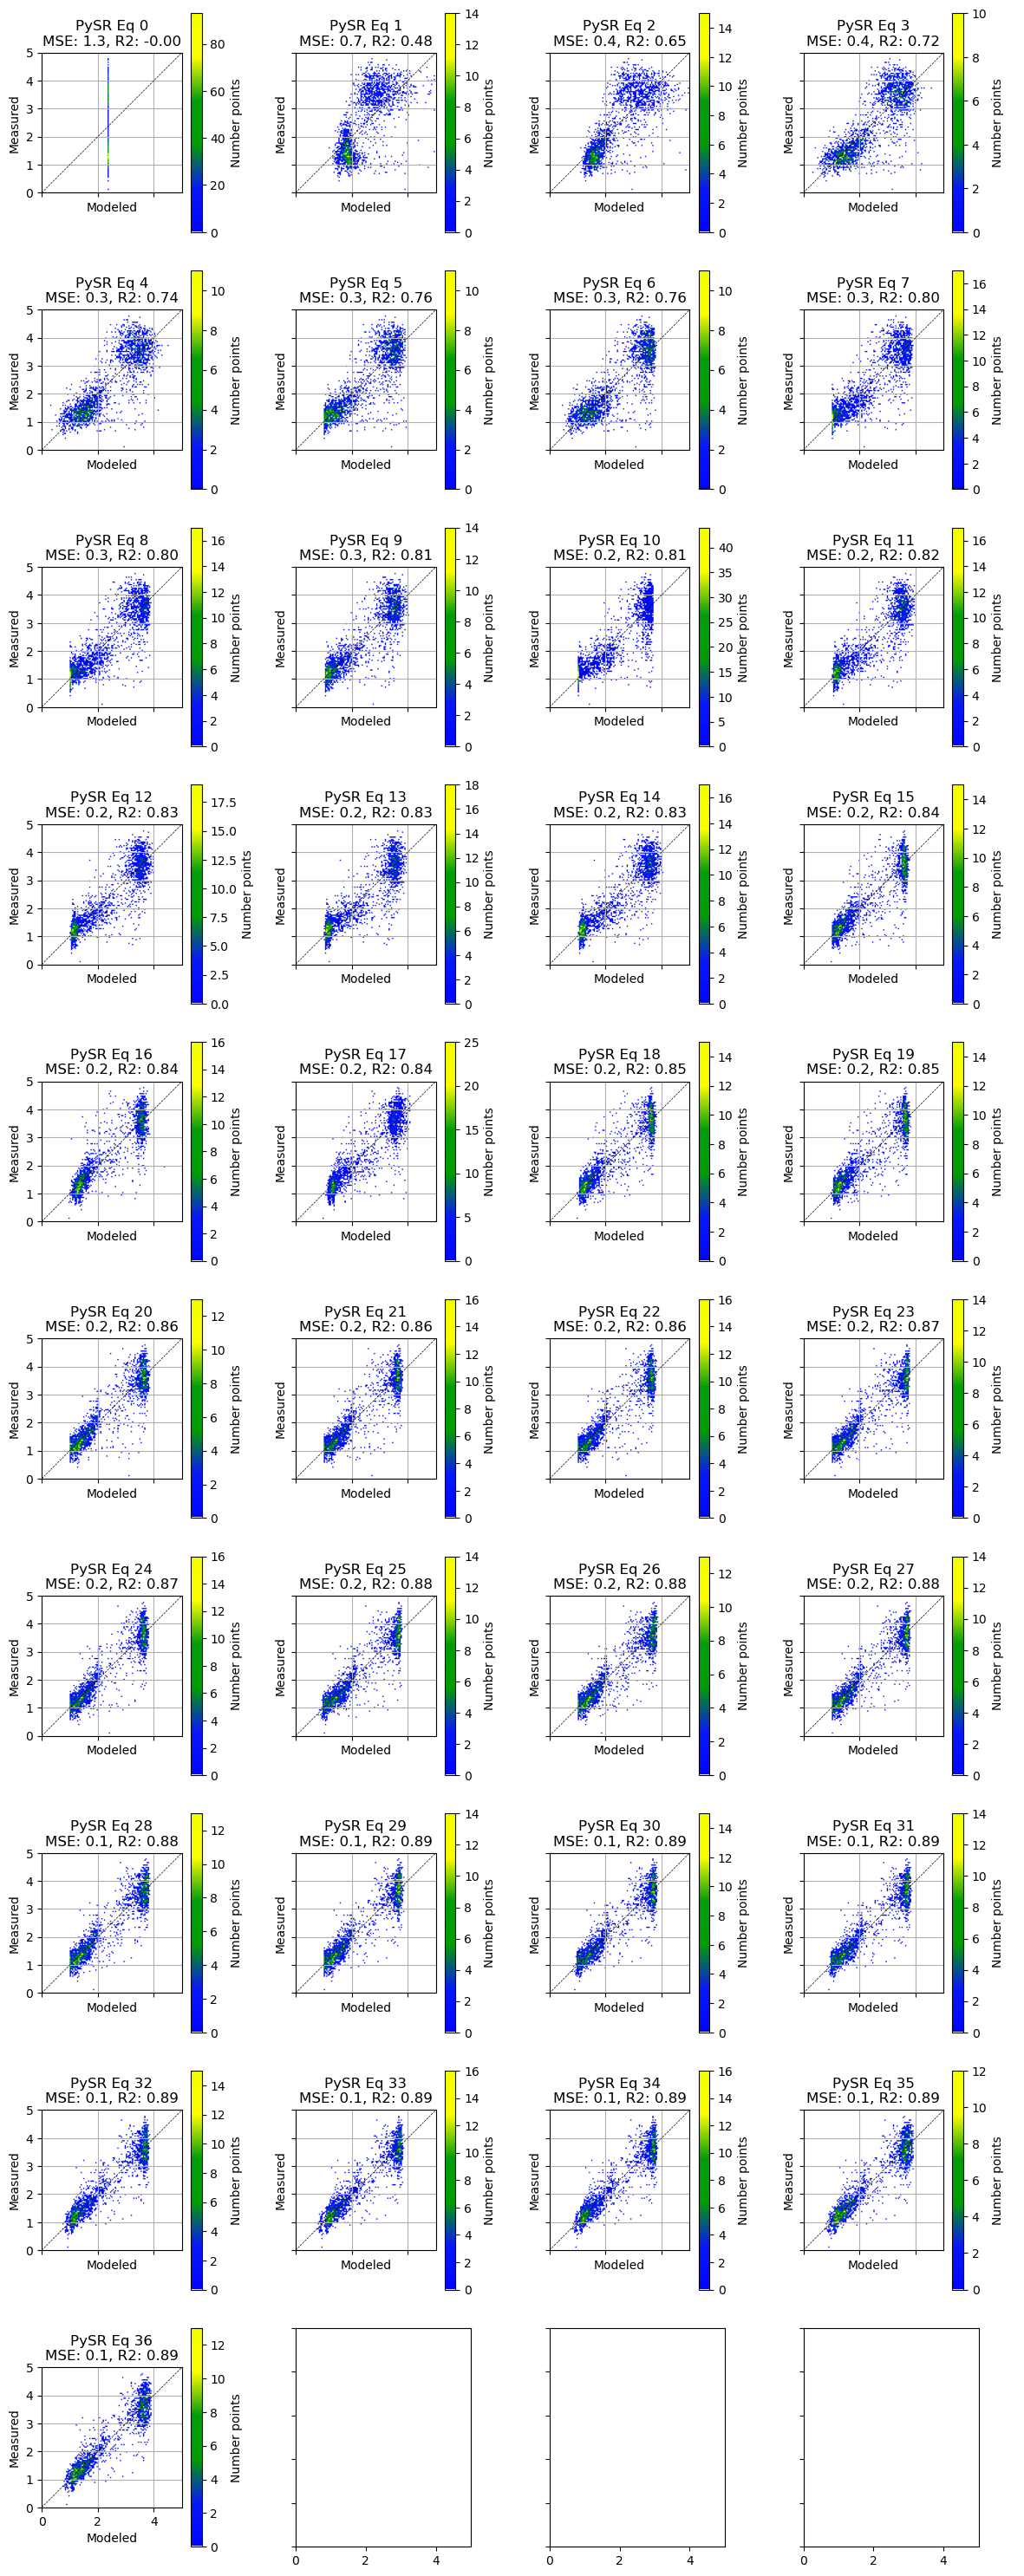

In [14]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, "#0004FF"),
    (0.2, "#0818F6"),
    (0.4, "#009d00"),
    (0.6, "#009d0a"),
    (0.8, "#fcfc01"),
    (1, "#f2ff00"),
], N=256)

num_eq = len(model.equations_)

fig_rows = int(np.ceil(num_eq / 4))
fig_cols = 4

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True,subplot_kw=dict(projection="scatter_density"))

it = np.linspace(0,num_eq-1,num_eq, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    # ypredict_simpler = pd.Series(np.asarray(ypredict_simpler).ravel(), index=y.index)

    density=ax.scatter_density(ypredict_simpler, y, cmap=white_viridis)

    # ax.plot(ypredict_simpler, y,'.')

    ax.grid(True)
    ax.set_xlabel("Modeled")
    ax.set_ylabel("Measured")
    ax.plot( [0,5], [0,5], linestyle='--', color='k', linewidth=0.5 )
    fig.colorbar(density, label='Number points', ax=ax)

    ax.set_aspect('equal')
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    mse = mean_squared_error(ypredict_simpler, y)
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nMSE: {mse:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

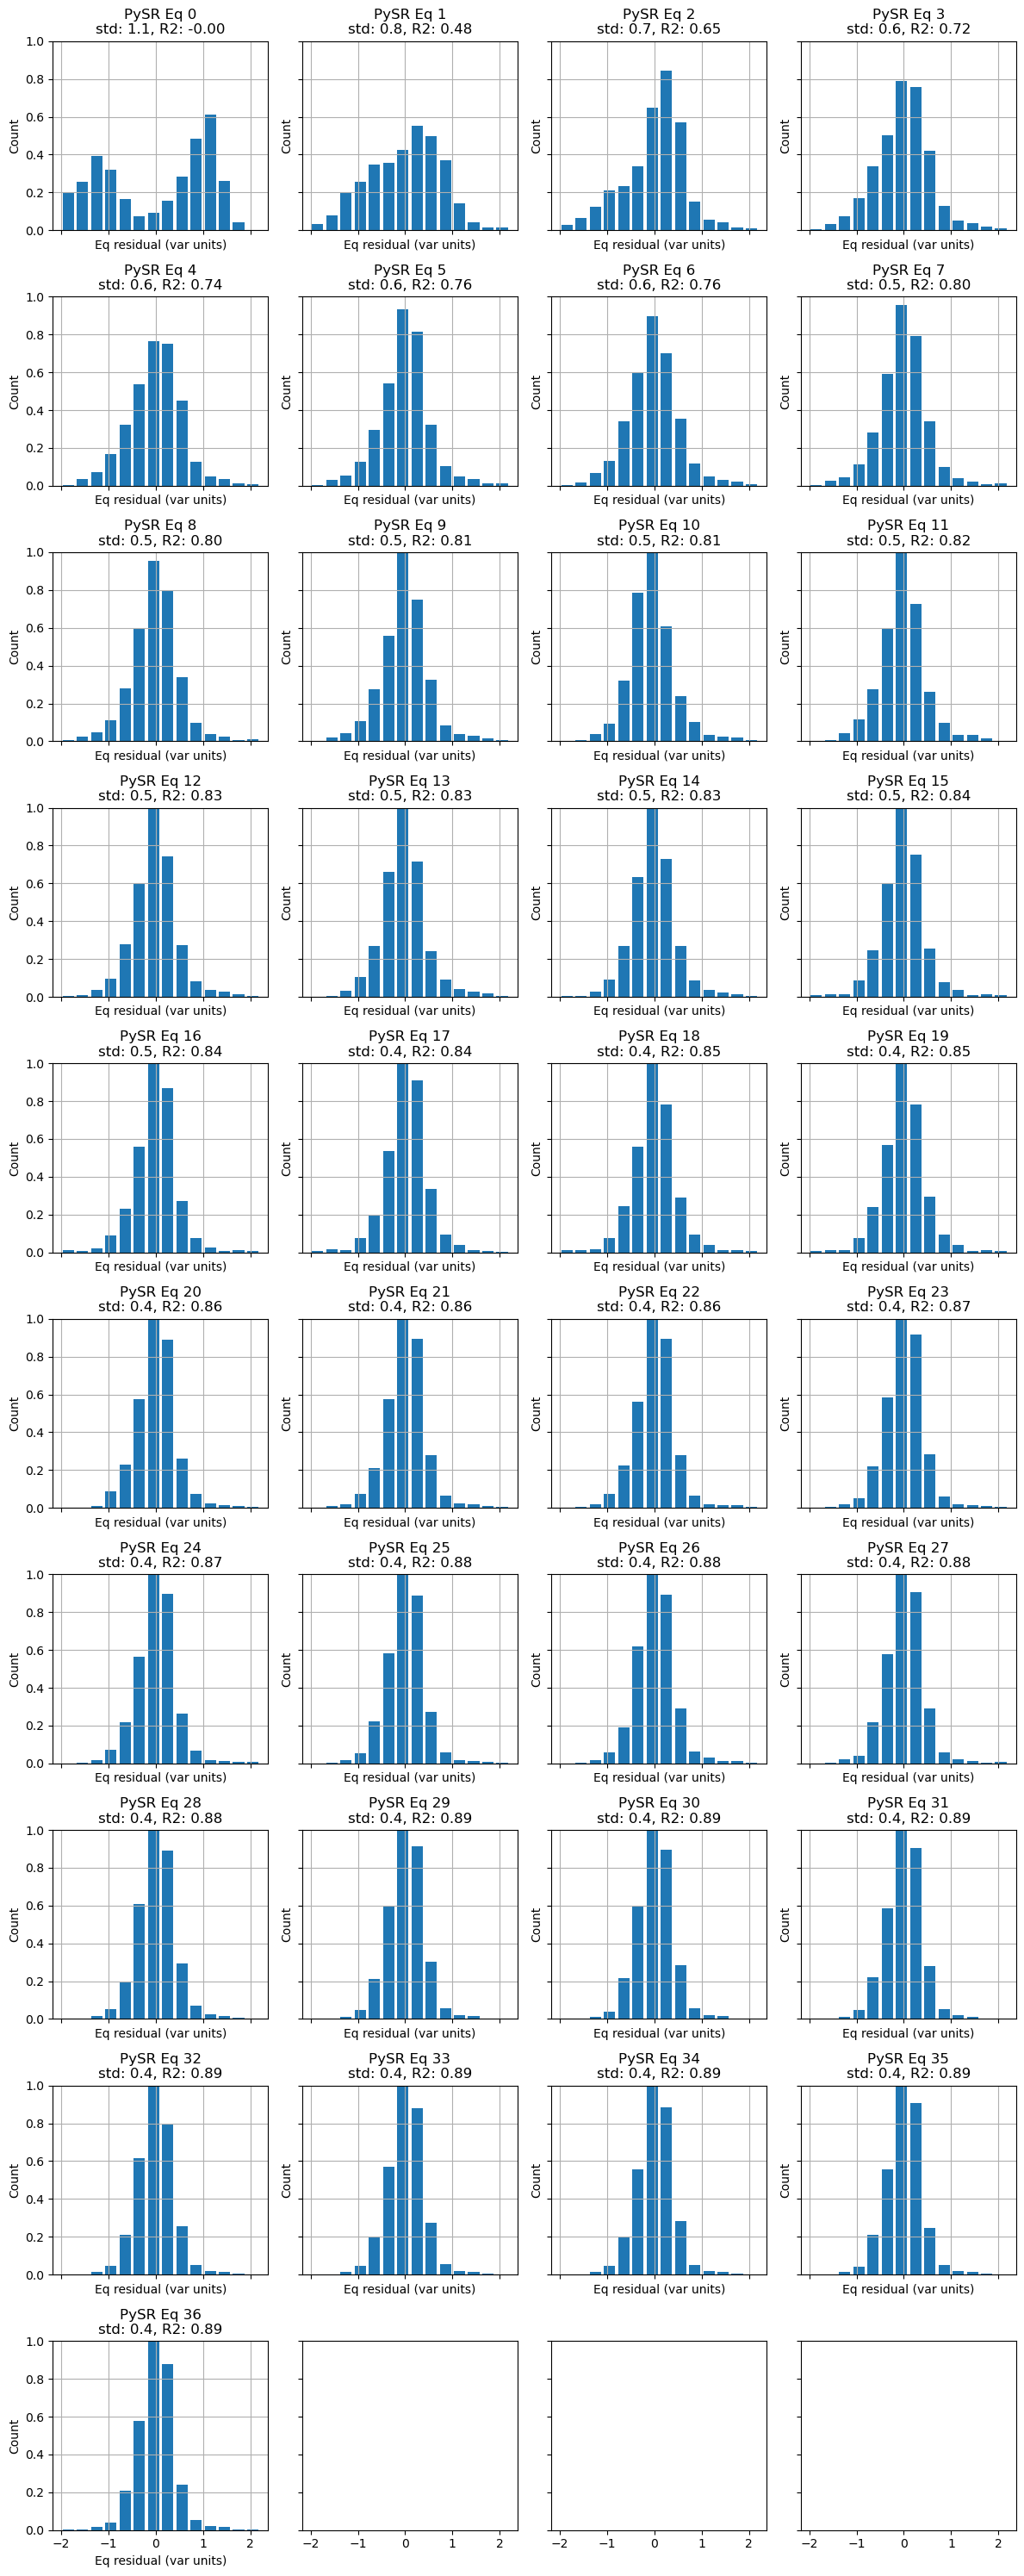

In [17]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(3*fig_cols, 3*fig_rows),sharey=True, sharex=True)

# Define bin interval and create bin edges
bin_interval = 0.3  # Adjust this value to change bin width
bins = np.arange(-2, 2 + bin_interval, bin_interval)

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.hist(ypredict_simpler- y, bins=bins, density=True, rwidth=0.8)
    ax.grid(True)
    ax.set_xlabel("Eq residual (var units)")
    ax.set_ylabel("Count")
    # ax.plot( [0,70], [0,70], linestyle='--', color='k' )
    ax.set_ylim(0, 1)

    N = len(y)
    mean = np.mean(ypredict_simpler - y)
    ddof = 1  # Use sample standard deviation
    d2 = abs(ypredict_simpler- y - mean)**2  # abs is for complex `a`
    var = d2.sum() / (N - ddof)  # note use of `ddof`
    std = var**0.5
    r2 = r2_score(y, ypredict_simpler)
    ax.set_title('PySR Eq ' + str(i) + f"\nstd: {std:.1f}, R2: {r2:.2f}")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Create a Taylor diagram with labeled data points and modified axes

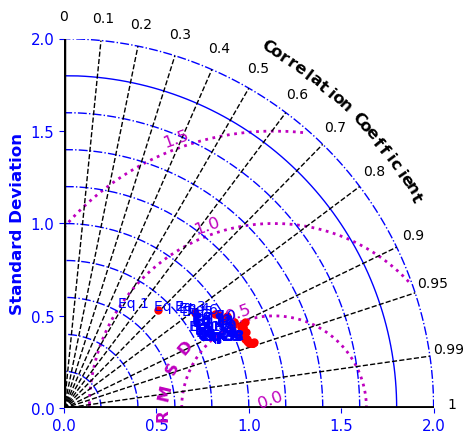

In [16]:

    
# number of equations found
n_e= len(found_equations)

it2 = np.linspace(0,n_e-1,n_e, dtype=int)  # Ensure indices are integers

# Prepare data for Taylor diagram
data = {}
# data=pd.DataFrame(data)

sdev = np.array([])
crmsd = np.array([])
ccoef = np.array([])

data['ref'] = y.values  # Store reference data in data dictionary
taylor_stats = sm.taylor_statistics(data['ref'],data['ref'])
sdev = np.append(sdev,[taylor_stats['sdev'][0]])
crmsd = np.append(crmsd,[taylor_stats['crmsd'][0]])
ccoef = np.append(ccoef,[taylor_stats['ccoef'][0]])

for i in it2:
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    data['pred'+str(i+1)] = ypredict_simpler  
    taylor_stats = sm.taylor_statistics(data['pred'+str(i+1)],data['ref'])
    sdev = np.append(sdev,[taylor_stats['sdev'][1]])
    crmsd = np.append(crmsd,[taylor_stats['crmsd'][1]])
    ccoef = np.append(ccoef,[taylor_stats['ccoef'][1]])
    
data = pd.DataFrame(data)
data

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Reference'] + ['Eq ' + str(i) for i in it2]    

# Produce the Taylor diagram

#     Label the points and change the axis options for SDEV, CRMSD, and CCOEF.
intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), 
                                   [0.9, 0.95, 0.99, 1]))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
                      markerLabelColor = 'b', 
                      tickRMS= np.arange(0,2,0.5),
                      tickRMSangle = 110.0, 
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                      tickSTD = np.arange(0,2,0.2), axismax = 2.0, 
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)
# plt.title('Taylor Diagram of Drone Thermal Camera Correction Models', fontsize=16)


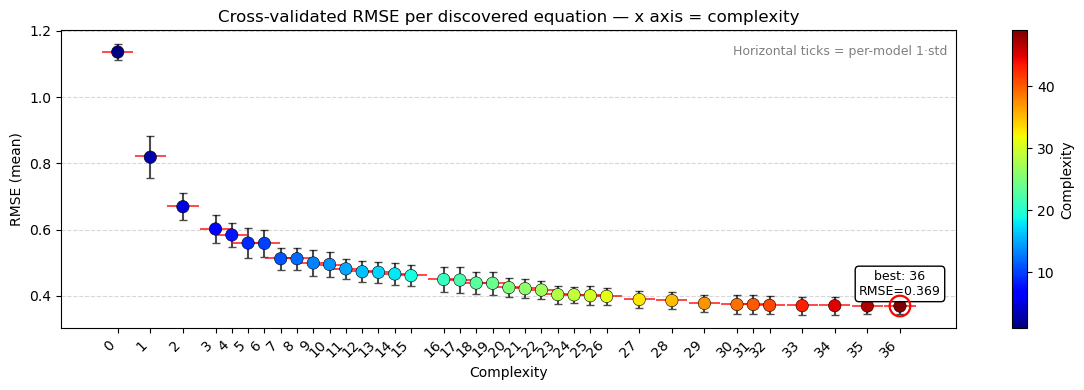

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

kf = KFold(n_splits=10, shuffle=True, random_state=0)
eq_indices = list(model.equations_.index)        # indices of discovered equations
scores = {idx: [] for idx in eq_indices}
residuals = {idx: [] for idx in eq_indices}  # collect residuals across folds for each equation

# Use explicit dataset target to avoid accidental shadowing of `y`
y_target = df.iloc[:, -2]

for _, test_idx in kf.split(X):
    X_test = X.iloc[test_idx]
    # handle y_target as pandas Series or numpy array
    if hasattr(y_target, "iloc"):
        y_test = y_target.iloc[test_idx]
    else:
        y_test = np.asarray(y_target)[test_idx]

    for idx in eq_indices:
        ypred = model.predict(X_test, index=idx)
        # ensure numpy arrays and flatten
        y_test_arr = np.asarray(y_test).ravel()
        ypred_arr = np.asarray(ypred).ravel()
        # RMSE per fold (kept for backward compatibility)
        scores[idx].append(np.sqrt(mean_squared_error(y_test_arr, ypred_arr)))
        # collect residuals for final std calculation
        residuals[idx].extend((y_test_arr - ypred_arr).tolist())

# summarize
rows = []
for idx in eq_indices:
    # compute residual std across all test predictions from CV folds
    try:
        resid_std = np.std(np.asarray(residuals[idx]), ddof=1)
    except Exception:
        resid_std = np.nan

    rows.append({
        "index": idx,
        "rmse_mean": np.mean(scores[idx]),
        "rmse_std": np.std(scores[idx], ddof=1),
        "resid_std": resid_std,
        "complexity": model.equations_.loc[idx, "complexity"],
        "equation": model.equations_.loc[idx, "equation"],
    })

df_cv = pd.DataFrame(rows).sort_values("rmse_mean")

# show top 10 by mean RMSE
# display(df_cv.head(10))

# --- Plot: rmse_mean vs. complexity (colored by complexity) -----------
# sort for plotting by numeric `complexity` so x-axis shows complexity order
plot_df = df_cv.sort_values("complexity").reset_index(drop=True)

x = plot_df["complexity"].values
labels = plot_df["index"].astype(str)
y_vals = plot_df["rmse_mean"].values
yerr = plot_df["rmse_std"].fillna(0).values
comp = plot_df["complexity"].values

fig, ax = plt.subplots(figsize=(12, 4))
# draw vertical error bars first (no markers)
ax.errorbar(x, y_vals, yerr=yerr, fmt='none', ecolor='black', alpha=0.7, capsize=3)
# scatter points colored by complexity
sc = ax.scatter(x, y_vals, c=comp, cmap='jet', s=80, edgecolor='k', linewidth=0.4, zorder=3)
# add colorbar for complexity
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Complexity')

# show equation index as tick labels at each complexity position
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlabel('Complexity')
ax.set_ylabel('RMSE (mean)')
ax.set_title('Cross-validated RMSE per discovered equation — x axis = complexity')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# draw small horizontal ticks at each model's 1·std value
# choose width as a small fraction of x span so ticks remain compact
if len(x) > 1:
    x_span = np.max(x) - np.min(x)
    width = max(x_span * 0.02, 0.1)
else:
    width = 0.1
# use per-model residual std values if present, otherwise fall back to rmse_std
resid_vals = plot_df.get("resid_std", plot_df.get("rmse_std")).fillna(0).values
ax.hlines(y=resid_vals, xmin=x - width, xmax=x + width, colors='red', alpha=0.8, linewidth=1.25, zorder=2)

# highlight best (lowest mean RMSE)
best_pos = np.nanargmin(y_vals)
best_x = x[best_pos]
ax.scatter(best_x, y_vals[best_pos], facecolors='none', edgecolors='red', s=220, linewidth=1.6, zorder=5)
ax.annotate(f"best: {plot_df.loc[best_pos, 'index']}\nRMSE={y_vals[best_pos]:.3f}",
            xy=(best_x, y_vals[best_pos]), xytext=(0, 8), textcoords='offset points',
            ha='center', fontsize=9, bbox=dict(boxstyle='round', fc='w'))

# label what the horizontal ticks represent
ax.text(0.99, 0.95, 'Horizontal ticks = per-model 1·std', transform=ax.transAxes,
        ha='right', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()
# -----------------------------------------------------------------------------

From the three plots it is evident that Equations before #8 are not necesarily robust. Still Equation 3 is simple and the error histogram is narrow. 

# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api